Modin Getting Started Example for Distributed Pandas
Importing and Organizing Data
In this example we will be generating a synthetic dataset and demonstrating stock Pandas operations running with Modin.

Let's start by importing all the necessary packages and modules

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [4]:
# ****** Do not change the code in this cell! It verifies that the notebook is being run correctly! ******

def verify_and_print_times(pandas_time, modin_time):
    if modin_time < pandas_time:
        print(f"Modin was {pandas_time / modin_time:.2f}X faster than stock pandas!")
        return
    print(
        f"Oops, stock pandas appears to be {modin_time / pandas_time:.2f}X faster than Modin in this case. "
        "This is unlikely but could happen sometimes on certain machines/environments/datasets. "
        "One of the most probable reasons is the excessive amount of partitions being assigned to a single worker. "
        "You may visit Modin's optimization guide in order to learn more about such cases and how to fix them: "
        "\nhttps://modin.readthedocs.io/en/latest/usage_guide/optimization_notes/index.html\n\n"
        "But first, verify that you're using the latest Modin version, also, try to use different executions, "
        "for basic usage we recommend non-experimental 'PandasOnRay'.\n"
        "Current configuration is:"
    )
    try:
        from modin.utils import get_current_execution

        execution = get_current_execution()
    except ImportError:
        # for modin version < 0.12.0
        try:
            from modin.utils import get_current_backend

            execution = get_current_backend()
        except ImportError:
            # for modin versions < 0.8.1
            execution = (
                "Can't deduce the current execution, your Modin version is too old!"
            )
    print(f"\tExecution: {execution}")
    try:
        import modin.config as cfg

        print(
            f"\tIs experimental: {cfg.IsExperimental.get()}\n"
            f"\tNumber of CPUs to utilize by Modin (check that Modin uses all CPUs on your machine): {cfg.CpuCount.get()}\n"
            f"\tIs in debug mode (debug mode may perform slower): {cfg.IsDebug.get()}"
        )
    except (ImportError, AttributeError):
        # for modin versions < 0.8.2
        print("\tCan't deduce Modin configuration, your Modin version is too old!")
    import modin

    print(f"\tModin version: {modin.__version__}")

How to Use Modin
We will also be importing stock Pandas as pandas and Modin as pd to show differentiation. You can see importing Modin is simple and does not require any additional steps.

In [4]:
import pandas

As an example, let’s creates a 80GB DataFrame by appending together 40 different 2GB DataFrames.

In [5]:
df = pandas.concat([pandas.DataFrame(np.random.randint(0, 100, size=(2**20, 2**8))) for _ in range(40)]) # Memory Error!

MemoryError: Unable to allocate 80.0 GiB for an array with shape (256, 41943040) and data type int64

Operating on out-of-memory data with Modin In order to work with data that exceeds memory constraints, you can use Modin to handle these large datasets.

Note: Uncomment below cell if you run on Intel oneAPI DevCloud

In [6]:
import ray
ray.shutdown()
ray.init(_memory=16000 * 1024 * 1024, object_store_memory=500 * 1024 * 1024,_driver_object_store_memory=500 * 1024 * 1024)

2023-01-05 16:15:51,220	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
2023-01-05 16:15:54,050	WARNING worker.py:2025 -- `driver_object_store_memory` is deprecated and will be removed in the future.


Python version:,3.9.15
Ray version:,2.0.1
Dashboard:,http://127.0.0.1:8265


In [7]:
import modin.pandas as pd

In [8]:
df = pd.concat([pd.DataFrame(np.random.randint(0, 100, size=(2**20, 2**8))) for _ in range(40)]) # 40x2GB frames -- Working!
df.info()

(raylet) Spilled 2048 MiB, 194 objects, write throughput 101 MiB/s. Set RAY_verbose_spill_logs=0 to disable this message.
(raylet) Spilled 4096 MiB, 386 objects, write throughput 106 MiB/s.
(raylet) Spilled 8192 MiB, 770 objects, write throughput 108 MiB/s.
(raylet) Spilled 16384 MiB, 1538 objects, write throughput 109 MiB/s.
(raylet) Spilled 32769 MiB, 3074 objects, write throughput 109 MiB/s.
(raylet) Spilled 65539 MiB, 6146 objects, write throughput 110 MiB/s.


<class 'modin.pandas.dataframe.DataFrame'>
Int64Index: 41943040 entries, 0 to 1048575
Columns: 256 entries, 0 to 255
dtypes: int64(256)
memory usage: 80.3 GB


In [ ]:
df = pandas.concat([pandas.DataFrame(np.random.randint(0, 100, size=(2**20, 2**8))) for _ in range(40)]) # Memory Error!

We will now generate a synthetic dataset using NumPy to use with Modin and save it to a CSV.

In [6]:
array=np.random.randint(low=100,high=10000,size=(2**18,2**8))
#array
np.savetxt("foo.csv", array, delimiter=",") #how to generate array

    Now we will convert the ndarray into a Pandas dataframe and display the first five rows. For stock pandas, the dataframe is being stored as pandas_df and for Modin, the same dataframe is being stored as modin_df. Let's try running the following cell with Pandas first.

In [7]:
%%time
pandas_df = pandas.read_csv("foo.csv", names=["col{}".format(i) for i in range(256)])
pandas_df.head()

CPU times: user 14.3 s, sys: 1.9 s, total: 16.2 s
Wall time: 24.5 s


,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,...,col246,col247,col248,col249,col250,col251,col252,col253,col254,col255
0,4767.0,3089.0,3548.0,6034.0,3363.0,8721.0,2693.0,3765.0,858.0,8001.0,...,9486.0,6973.0,4441.0,3176.0,1917.0,1647.0,9780.0,7457.0,1050.0,1461.0
1,2260.0,5244.0,6815.0,3067.0,3515.0,5022.0,8425.0,3568.0,5979.0,810.0,...,1116.0,7602.0,3253.0,2441.0,3473.0,5132.0,9582.0,7240.0,3147.0,5618.0
2,2701.0,7366.0,5409.0,8283.0,1926.0,162.0,3699.0,4806.0,1124.0,6092.0,...,8667.0,4262.0,7898.0,9214.0,7412.0,679.0,4907.0,208.0,3769.0,6365.0
3,8445.0,1539.0,4932.0,6434.0,5189.0,318.0,3689.0,108.0,1474.0,3929.0,...,6476.0,9837.0,2614.0,1222.0,8125.0,3755.0,9306.0,5468.0,9612.0,1975.0
4,7196.0,2649.0,8517.0,7852.0,195.0,561.0,5036.0,6279.0,9169.0,6055.0,...,9126.0,1743.0,4800.0,6538.0,4267.0,9586.0,6958.0,8678.0,2900.0,8944.0


Now let's run the same code, but use Modin instead of stock Pandas.

Note the speedup!

In [8]:
%%time
modin_df=pd.read_csv("foo.csv", names=["col{}".format(i) for i in range(256)])
modin_df.head()

CPU times: user 1.02 s, sys: 562 ms, total: 1.58 s
Wall time: 8.12 s


,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,...,col246,col247,col248,col249,col250,col251,col252,col253,col254,col255
0,4767.0,3089.0,3548.0,6034.0,3363.0,8721.0,2693.0,3765.0,858.0,8001.0,...,9486.0,6973.0,4441.0,3176.0,1917.0,1647.0,9780.0,7457.0,1050.0,1461.0
1,2260.0,5244.0,6815.0,3067.0,3515.0,5022.0,8425.0,3568.0,5979.0,810.0,...,1116.0,7602.0,3253.0,2441.0,3473.0,5132.0,9582.0,7240.0,3147.0,5618.0
2,2701.0,7366.0,5409.0,8283.0,1926.0,162.0,3699.0,4806.0,1124.0,6092.0,...,8667.0,4262.0,7898.0,9214.0,7412.0,679.0,4907.0,208.0,3769.0,6365.0
3,8445.0,1539.0,4932.0,6434.0,5189.0,318.0,3689.0,108.0,1474.0,3929.0,...,6476.0,9837.0,2614.0,1222.0,8125.0,3755.0,9306.0,5468.0,9612.0,1975.0
4,7196.0,2649.0,8517.0,7852.0,195.0,561.0,5036.0,6279.0,9169.0,6055.0,...,9126.0,1743.0,4800.0,6538.0,4267.0,9586.0,6958.0,8678.0,2900.0,8944.0


Let's now visualize this speedup from Modin with a plot!

In [9]:
def plotter(outputdict):
    fig = plt.figure(figsize = (10, 5)) 
    plt.bar(outputdict.keys(),outputdict.values(),color='blue',width=0.4)
    plt.xlabel("Python Package")
    plt.ylabel("Runtime(seconds)")
    plt.show()

Pandas Time(seconds): 11.247676849365234 
Modin Time(seconds): 3.129828453063965
Modin was 3.59X faster than stock pandas!


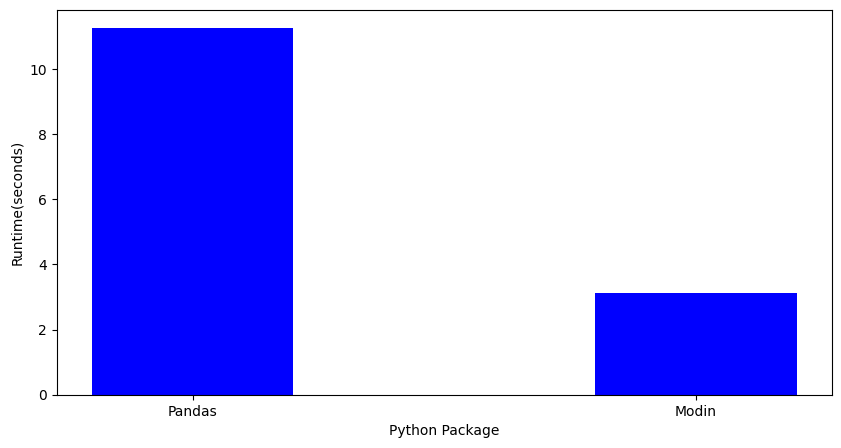

In [10]:
t0 = time.time()
pandas_df = pandas.read_csv("foo.csv", names=["col{}".format(i) for i in range(256)])
pandas_time = time.time()- t0

t1 = time.time()
modin_df = pd.read_csv("foo.csv", names=["col{}".format(i) for i in range(256)])
modin_time = time.time() - t1

print("Pandas Time(seconds):",pandas_time,"\nModin Time(seconds):",modin_time)
verify_and_print_times(pandas_time, modin_time)
outputDict={"Pandas":pandas_time,"Modin":modin_time}
plotter(outputDict)

Other DataFrame Function Performance Example
We will now show the speedup in performance from Modin compared to stock Pandas with a few common functions.

Like before, pandas_df is for stock Pandas, modin_df is for Modin.

df.mean()

In [11]:
# Mean
t2 = time.time()
pandas_df.mean(axis=0)
pandas_time=time.time()- t2
print(" stock Pandas wall time for completion in seconds:",pandas_time)

 stock Pandas wall time for completion in seconds: 0.2341015338897705


In [12]:
# Mean
t3 = time.time()
modin_df.mean(axis=0)
modin_time=time.time()- t3
print("Modin wall time for completion in seconds:",modin_time)

Modin wall time for completion in seconds: 0.09839177131652832


In [13]:
verify_and_print_times(pandas_time, modin_time)

Modin was 2.38X faster than stock pandas!
